## Loading

In [1]:
# import sys
# !pip --proxy http://httpproxy.vip.ebay.com:80 install seaborn --user
# !pip --proxy http://httpproxy.vip.ebay.com:80 install --upgrade pip --user

In [25]:
import os
import pandas as pd
import numpy as np
# import dask
# import dask.dataframe as dd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as st
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_roc_curve
import pickle
%matplotlib inline

# os.environ

In [3]:
# df = pd.read_csv(os.environ.get('KRYLOV_DATA_DIR') + "/" + os.environ.get('KRYLOV_PRINCIPAL') + "/" + "9_23_hotness_01_percent.csv")
df = pd.read_csv('/home/mkareev/9_23_hotness_01_percent.csv')

In [4]:
df.head()

,GUID,SESSION_SKEY,SITE_ID,SESSION_START_DT,ITEM_ID,MIN_SEQNUM,MIN_EVENT_TIMESTAMP,USER_ID,PLATFORM,asp_usd,...,CATEG_GMB_P1D_BEFORE_VI,TTL_BI_P1D_BEFORE_VI,TTL_GMB_P1D_BEFORE_VI,ITEM_BI_SHARE_IN_CATEG_P1D_BEFORE_VI,ITEM_GMB_SHARE_IN_CATEG_P1D_BEFORE_VI,CATEG_BI_SHARE_IN_TTL_P1D_BEFORE_VI,CATEG_GMB_SHARE_IN_TTL_P1D_BEFORE_VI,BI_INVERSE_FREQUENCY_SCORE,GMB_INVERSE_FREQUENCY_SCORE,rnk
0,9937d3881710a6e6f02cd2e4ff7ad788,38051181213890,3,2020-07-30,131157708197,43,2020-07-30 17:15:51,0,Browser: mWeb,5.0,...,1.538424e+05,6525144,2.188364e+08,0.00017,0.000218,0.001804,0.000703,0.001074,0.001582,0.006
1,d4f39376166e79924e73a830012f8ea5,38055995449570,0,2020-08-05,313166484131,608,2020-08-05 07:18:45,1840615439,Apps: iPhone,60.0,...,4.122317e+05,6624528,2.202547e+08,NaN,NaN,0.001694,0.001872,NaN,NaN,0.006
2,ace49b041640a9c0b93ba28affff02e4,38047619149900,0,2020-07-26,402320794556,31,2020-07-26 14:20:40,0,Browser: Core site,503.0,...,1.881010e+07,6174417,1.871884e+08,NaN,NaN,0.048301,0.100488,NaN,NaN,0.006
3,8891830716d4b9474906df10011cd54d,38051590936770,3,2020-07-31,174370805761,2454,2020-07-31 06:52:23,1123359449,Apps: iPhone,46.0,...,1.332561e+06,6367867,2.133461e+08,NaN,NaN,0.021025,0.006246,NaN,NaN,0.006
4,963d16581730aad74a104d04ffa8f650,38049170526130,3,2020-07-28,301699730415,1,2020-07-28 09:24:12,0,Browser: Core site,18.0,...,8.696573e+04,7063671,2.377354e+08,NaN,NaN,0.000338,0.000366,NaN,NaN,0.006


## Assessing the data

In [5]:
# quickly filling out NaNs with zeroes, otherwise astype() won't work
df = df.fillna(0)

# dropping unused columns
to_drop =['ITEM_ID', 'GUID','SESSION_SKEY','SITE_ID', 'MIN_SEQNUM', 'MIN_SEQNUM', 'USER_ID', 'SEQNUM_RANK', 'show_cnt', 'rnk', 'SELLER_ID',\
         'SESSION_START_DT', 'MIN_EVENT_TIMESTAMP', 'SESSION_MIN_TIMESTAMP',\
         'active_item_yn', 'AUCT_START_DT', 'BUYER_LAST_TRX_DT_BEFORE_VI']
df = df.drop(columns = to_drop, axis = 1)

# Changing columns' types to make the dataframe more performant
# type_mapping = {'PLATFORM': 'category', 'stp_yn': 'int8', 'map_yn': 'int8', 'mdm_yn': 'int8', 'sme_type_dt': 'int8', 'vi_coupon_show': 'int8',\
#                'vp_yn': 'int8', 'return_accept_yn': 'int8', 'return_duration_in_vi': 'int8',\
#                'qty_available': 'int16', 'qty_sold': 'int16', 'show_view_1hr_cnt': 'int16', 'show_view_24hr_cnt': 'int16',\
#                'show_watch_1hr_cnt': 'int16', 'show_watch_24hr_cnt': 'int16','show_sld_1hr_cnt': 'int16', 'show_sld_24hr_cnt': 'int16',\
#                'show_last_item_cnt': 'int16', 'show_limited_time_cnt': 'int16', 'show_limited_qty_cnt': 'int16' ,\
#                'BIN_CNT': 'int16', 'BID_CNT': 'int16','OFFER_CNT': 'int16', 'WATCH_CNT': 'int16', 'ASQ_CNT': 'int16',\
#                'BBO_CNT': 'int16', 'BBOC_CNT': 'int16', 'CONV_YN': 'int8', 'MQ_YN': 'int8', 'FP_YN': 'int8', 'BO_YN': 'int8',\
#                'FREE_SHIPPING_YN': 'int8', 'ITEM_CONDITION': 'category', 'ITEM_CONDITION_DETAIL': 'category', 'META_CATEG_NAME': 'category',\
#                'CATEG_LVL2_NAME': 'category','VERTICAL': 'category', 'RETURN_ACCPT_YN_NEW': 'int8', 'RETURN_TYPE': 'category', 'PHOTO_CNT': 'int8',\
#                'AUCT_START_DT': 'datetime64[ns]', 'LIST_AGE_DAY': 'int16', 'BUYER_SEGMENT': 'category', 'BUYER_SEC_FROM_SESSION_START_TO_VI': 'int16' ,\
#                'BUYER_CNTRY': 'category', 'SITE_NAME': 'category', 'SELLER_SEGMENT': 'category', 'SELLER_ETRS_YN':'category',\
#                'SELLER_CNTRY': 'category','TRX_DOMESTIC_YN': 'category', 'SELLER_GREATER_CHINA_YN': 'category'}

type_mapping = {'PLATFORM': 'category', 'stp_yn': 'int8', 'map_yn': 'int8', 'mdm_yn': 'int8', 'sme_type_dt': 'int8', 'vi_coupon_show': 'int8',\
               'vp_yn': 'int8', 'return_accept_yn': 'int8', 'return_duration_in_vi': 'int8',\
               'CONV_YN': 'int8', 'MQ_YN': 'int8', 'FP_YN': 'int8', 'BO_YN': 'int8',\
               'FREE_SHIPPING_YN': 'int8', 'ITEM_CONDITION': 'category', 'ITEM_CONDITION_DETAIL': 'category', 'META_CATEG_NAME': 'category',\
               'CATEG_LVL2_NAME': 'category','VERTICAL': 'category', 'RETURN_ACCPT_YN_NEW': 'int8', 'RETURN_TYPE': 'category', 'PHOTO_CNT': 'int8',\
               'BUYER_SEGMENT': 'category',\
               'BUYER_CNTRY': 'category', 'SITE_NAME': 'category', 'SELLER_SEGMENT': 'category', 'SELLER_ETRS_YN':'category',\
               'SELLER_CNTRY': 'category','TRX_DOMESTIC_YN': 'category', 'SELLER_GREATER_CHINA_YN': 'category'}

df = df.astype(type_mapping)

# have to keep float64 as it is, b/c otherwise np.log1p() refuses to work
# float64 to float32
# float64_vars = df.select_dtypes(include = 'float64').columns.to_list()
# df[float64_vars] = df[float64_vars].astype('float32')

In [6]:
# Pairwise correlations: takes time to run and not very informative given how many features are out there
# corrmat = df.corr()
# f, ax = plt.subplots(figsize = (28, 20))
# sns.heatmap(corrmat, vmax = 0.8, center = 0, square = True, cmap = plt.cm.Reds)
# plt.show()

In [7]:
# same but in text
# def histogram_intersection(a, b):
#     v = np.minimum(a, b).sum().round(decimals=1)
#     return v
# df.corr(method = histogram_intersection)

In [8]:
# barchart w/ correlations
# plt.figure(figsize = (16,6))
# corrmat['BBOWAC_YN'].sort_values(ascending = False).plot(kind = 'bar')  # update the col
# plt.tight_layout()

In [9]:
# Distributions of numeric features:
# TAKES TIME TO RUN
# Finding numeric features
numeric_vars = df.select_dtypes(exclude = ['category', 'object'])
# for c in numeric_vars.columns:
#     sns.displot(df[c], fit = norm)
#     fig = plt.figure()
#     st.probplot(df[c], plot = plt)

# TAKES TIME TO RUN
# fig, axs = plt.subplots(ncols=2, nrows = 10, figsize=(12, 120))
# plt.subplots_adjust(right=2)
# plt.subplots_adjust(top=2)

# for i in range(1, len(numeric_vars.columns)):
#     feature = numeric_vars.columns[i]
#     plt.subplot(len(numeric_vars.columns), 3, i)
#     sns.scatterplot(x=feature, y='BBOWAC_YN', data=df)  # update y
#     plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
#     plt.ylabel('BBOWAC_YN', size=15, labelpad=12.5)  # update the name         
# plt.show()

# for c in numeric_vars:
#     sns.displot(df, x = c, kind = "kde")

In [10]:
# Checking cardinality of categorical variables
# TAKES TIME TO RUN
# categorical_vars = df.select_dtypes(include = 'category')
# for c in categorical_vars.columns:
#     df[c].value_counts(normalize = True).plot.barh()
#     plt.title(label = c)
#     plt.show()

<AxesSubplot:>

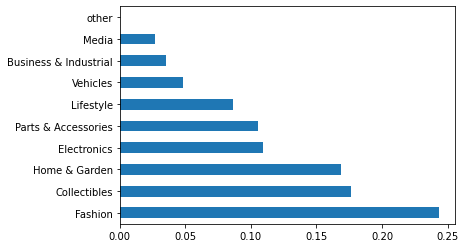

In [11]:
# Will lump Unknown, 0, and Real Estate and call 'other' for VERTICAL
# Will drop META_CATEG_NAME and CATEG_LVL2_NAME b/c they have too many distinct values 
vertical_mask = ['Unknown', 0, 'Real Estate']
df['Vertical_new'] = df['VERTICAL'].apply(lambda x: 'other' if x in vertical_mask else x)
df['Vertical_new'] = df['Vertical_new'].astype('category')
df.drop(labels = ['META_CATEG_NAME', 'CATEG_LVL2_NAME','VERTICAL'], axis = 1, inplace = True)
df['Vertical_new'].value_counts(normalize = True).plot.barh()

In [12]:
# checking NaNs once again
df.isna().sum()

PLATFORM                                0
asp_usd                                 0
stp_yn                                  0
map_yn                                  0
mdm_yn                                  0
                                       ..
CATEG_BI_SHARE_IN_TTL_P1D_BEFORE_VI     0
CATEG_GMB_SHARE_IN_TTL_P1D_BEFORE_VI    0
BI_INVERSE_FREQUENCY_SCORE              0
GMB_INVERSE_FREQUENCY_SCORE             0
Vertical_new                            0
Length: 87, dtype: int64

## ML

In [15]:
X, y = df.drop(['BBOWAC_YN'], axis = 1), df['BBOWAC_YN']

In [16]:
# need to do it again, b/c X != df
categorical_vars = X.select_dtypes(include = ['category', 'object'])
numeric_vars = X.select_dtypes(exclude = ['category', 'object', 'int8'])

In [19]:
# Pipelines
def get_cat_cols(X):
    return X[categorical_vars.columns]
def get_num_cols(X):
    return X[numeric_vars.columns]

num_cols_pipeline = Pipeline([
    ('get_num_cols', FunctionTransformer(get_num_cols, validate = False)),
    ('min_max', MinMaxScaler())
])
cat_cols_pipeline = Pipeline([
    ('get_cat_cols', FunctionTransformer(get_cat_cols, validate = False)),
    ('onehot', FunctionTransformer(pd.get_dummies, validate = False))
])
steps_ = FeatureUnion([
    ('num_cols', num_cols_pipeline),
    ('cat_cols', cat_cols_pipeline)
])
full_pipeline = Pipeline([('steps_', steps_)])

In [21]:
X_transformed = full_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state = 2, test_size = 0.25)

In [22]:
# Train RandomForestClassifier()
rf = RandomForestClassifier(n_estimators = 400)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400)

In [23]:
# Score the model
probs_train = rf.predict_proba(X_train)[:, 1]
probs_test = rf.predict_proba(X_test)[:, 1]
print("score train: {}".format(roc_auc_score(y_train, probs_train)))
print("score test: {}".format(roc_auc_score(y_test, probs_test)))

score train: 0.9999999999999999
score test: 1.0


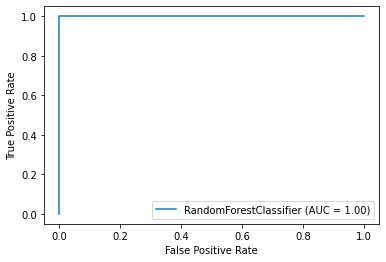

In [26]:
# ROC curve
disp = plot_roc_curve(rf, X_test, y_test)

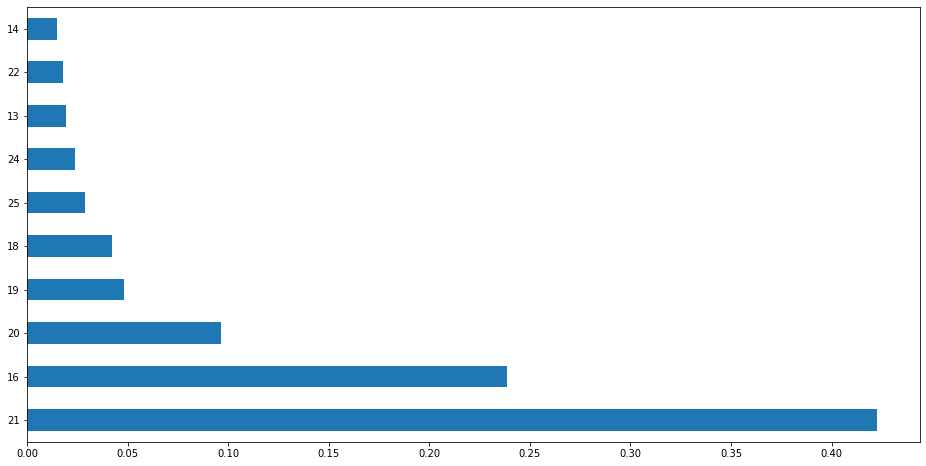

In [34]:
# Feature importance
# need to think how to properly get columns' names (because we applied get_dummies to them)
plt.figure(figsize=(16,8))
(pd.Series(rf.feature_importances_)
   .nlargest(10)
   .plot(kind='barh'))
plt.show()

In [27]:
# save the model
pickle.dump(rf, open('9_24_rf_model', 'wb'))

# if you want to load the model
# rf = pickle.load(open('9_24_rf_model', 'rb'))

## Charting

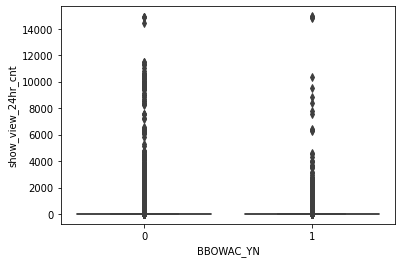

In [36]:
# Create the boxplot
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")
ax = sns.boxplot(x = 'BBOWAC_YN', y = 'show_view_24hr_cnt', data = df)
# Set the `xlim`
# ax.set(xlim=(0, 100))
# Show the plot
plt.show()

/home/mkareev/.local/lib/python3.6/site-packages/seaborn/categorical.py:373: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)


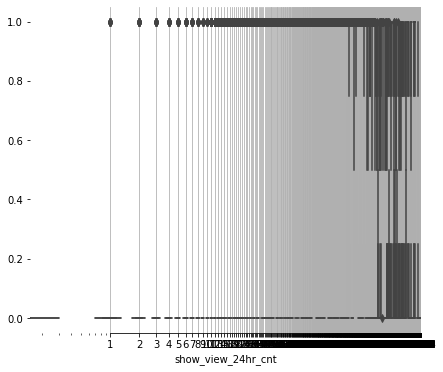

In [37]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="show_view_24hr_cnt", y="BBOWAC_YN", data=df,
            width=.6, palette="vlag")

# Add in points to show each observation
# sns.stripplot(x="distance", y="method", data=planets,
#               size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [ ]:
sns.catplot(data = df, y = 'BBOWAC_YN', x = 'show_view_24hr_cnt')